In [45]:
from raw_python.Bagging import create_models, create_bags, evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import random
from raw_python.BaggingSA import BaggingSA
from typing import Literal, Tuple
from raw_python.Bagging import predict
import sklearn
from raw_python.plots_manager import *
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from tabulate import tabulate


# PARAMS

+---------+-------+------+-------+----------+---------+---------------+
| dataset | theta | beta | gamma | accuracy | fitness | spearman_corr |
+---------+-------+------+-------+----------+---------+---------------+
| digits  | 0.25  | 0.5  | 0.25  |  0.939   |  0.37   |     0.188     |
+---------+-------+------+-------+----------+---------+---------------+


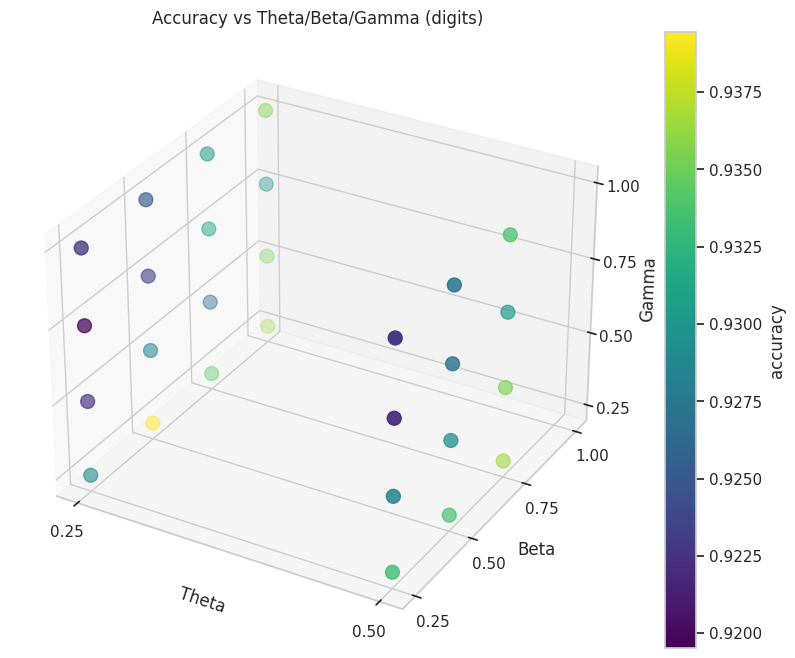

In [46]:
df = pd.read_csv('./../res/bagging_sa_params.csv')

grouped = df.groupby(['dataset', 'theta', 'beta', 'gamma']).agg({
    'accuracy': 'mean',
    'fitness': 'mean',
    'spearman_corr': 'mean'
}).reset_index()


best_by_dataset = grouped.loc[grouped.groupby('dataset')['accuracy'].idxmax()]
tmp = best_by_dataset.copy().round(3)
print(tabulate(tmp, headers='keys', tablefmt='pretty', showindex=False))


# 3D Scatter Plot Function
def plot_metric_3d(df, dataset, metric, title):
    df_tmp = df[df['dataset'] == dataset]
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(df_tmp['theta'], df_tmp['beta'], df_tmp['gamma'], c=df_tmp[metric], cmap='viridis', s=100)
    ax.set_xlabel('Theta')
    ax.set_ylabel('Beta')
    ax.set_zlabel('Gamma')

    ax.set_xticks(df_tmp['theta'].unique())
    ax.set_yticks(df_tmp['beta'].unique())
    ax.set_zticks(df_tmp['gamma'].unique())

    ax.set_title(title)
    fig.colorbar(sc, ax=ax, label=metric)
    plt.show()


datasets = grouped['dataset'].unique()

for dataset in datasets:
    plot_metric_3d(grouped, dataset, 'accuracy', f'Accuracy vs Theta/Beta/Gamma ({dataset})')
    # plot_metric_3d(grouped, 'fitness', 'Fitness vs Theta/Beta/Gamma')
    # plot_metric_3d(grouped, 'spearman_corr', 'Spearman Corr vs Theta/Beta/Gamma')

In [47]:
# Optionally average over replicates
grouped = df.groupby(['theta', 'beta', 'gamma']).agg({
    'accuracy': 'mean',
    'fitness': 'mean',
    'spearman_corr': 'mean'
}).reset_index()

# Define a function to plot 3D scatter
def plot_3d_metric(data, metric, title):
    fig = px.scatter_3d(
        data, x='theta', y='beta', z='gamma',
        color=metric, size_max=10,
        title=title,
        color_continuous_scale='Viridis',
        labels={'theta': 'Theta', 'beta': 'Beta', 'gamma': 'Gamma'}
    )
    fig.update_traces(marker=dict(size=5))
    fig.show()

# Create interactive 3D plots
plot_3d_metric(grouped, 'accuracy', 'Accuracy vs Theta/Beta/Gamma')
plot_3d_metric(grouped, 'fitness', 'Fitness vs Theta/Beta/Gamma')
plot_3d_metric(grouped, 'spearman_corr', 'Spearman Correlation vs Theta/Beta/Gamma')

# RESULT COMPARISON PLOTS  

In [48]:
def create_comparison_plot(df: pd.DataFrame) -> None:
    # fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
    plt.figure(figsize=(12, 4))
    
    X = df['nTrees'].unique()
    dataset_name = df['Dataset'].values[0]
    
    y_data=[
        # ("DT", "Decision tree"),
        ("Bagging", "Bagging"),
        # ("BaggingCustom", "Bagging custom"),
        # ("RF", "Random forrest"),
        ("BaggingSA", "Bagging SA")
    ]

    for df_name, plt_name in y_data:
        Y, Y_std = df[df_name], df[df_name + "_STD"]
        plt.plot(X, Y, marker='o', label=plt_name)
        plt.fill_between(X, Y - Y_std, Y + Y_std, alpha=0.2)

    plt.title(f"Accuracy per trees amount for dataset: {dataset_name}")
    plt.xlabel('Number of Trees')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(X)
    plt.grid()
    
    plt.show()
    
    

+---------+--------+-------+---------+-------+---------------+-----------+--------+-------------+--------+-------------------+---------------+
| Dataset | nTrees |  DT   | Bagging |  RF   | BaggingCustom | BaggingSA | DT_STD | Bagging_STD | RF_STD | BaggingCustom_STD | BaggingSA_STD |
+---------+--------+-------+---------+-------+---------------+-----------+--------+-------------+--------+-------------------+---------------+
| digits  |   10   | 0.86  |  0.928  | 0.949 |     0.927     |   0.932   | 0.016  |    0.015    | 0.008  |       0.021       |     0.015     |
| digits  |   20   | 0.858 |  0.937  | 0.965 |     0.934     |   0.948   | 0.017  |    0.014    | 0.009  |       0.016       |     0.013     |
| digits  |   30   | 0.858 |  0.944  | 0.97  |     0.942     |   0.947   | 0.018  |    0.017    | 0.009  |       0.012       |     0.012     |
| digits  |   40   | 0.861 |  0.945  | 0.973 |     0.941     |   0.952   | 0.016  |    0.014    | 0.007  |       0.013       |     0.012     |

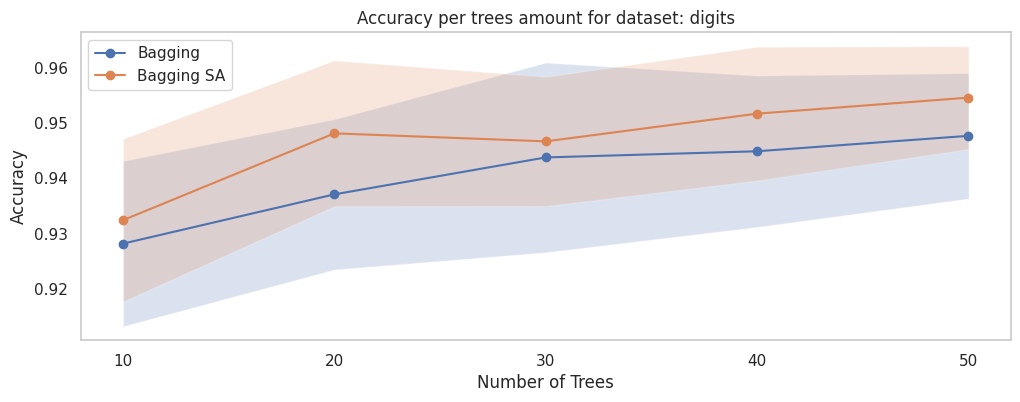

In [49]:
from tabulate import tabulate


files = glob.glob('./../res/accuracy_comparison_*.csv')
dfs = [pd.read_csv(f) for f in files]

for df in dfs:
    df_aggregated = df.groupby(['nTrees']).agg(
        Dataset=('Dataset', 'first'),
        nTrees=('nTrees', 'first'),
        
        DT=('DT', 'mean'),
        Bagging=('Bagging', 'mean'),
        RF=('RF', 'mean'),
        BaggingCustom=('BaggingCustom', 'mean'),
        BaggingSA=('BaggingSA', 'mean'),

        DT_STD=('DT','std'),
        Bagging_STD=('Bagging','std'),
        RF_STD=('RF','std'),
        BaggingCustom_STD=('BaggingCustom','std'),
        BaggingSA_STD=('BaggingSA','std'),
    ).reset_index(drop=True).dropna()
    
    tmp = df_aggregated.copy().round(3)
    print(tabulate(tmp, headers='keys', tablefmt='pretty', showindex=False))
    create_comparison_plot(df_aggregated)
    print()
    
    